# Detecting Exoplanets using Transit Photometry

Extrasolar planets - small, non luminous objects orbiting distant stars - are hard to detect, even with sophisticated telescopes. However, there are a bunch of different methods that an enterprising astronomer can use to make indirect detections. These approaches can be extended even further, and used to extract useful information like the radii and periods of their orbits, and the sizes of the exoplanets themselves. More information about searching for exoplanets can be found [here](http://www.planetary.org/explore/space-topics/exoplanets/how-to-search-for-exoplanets.html), and information about the specific method we will focus on today can be found [here](http://www.planetary.org/explore/space-topics/exoplanets/transit-photometry.html). 

Today, we use a method that uses time-series photometry to look at a star and detect tiny drops in its luminosity whenever a planet passes in front of it along our line of sight. 

<img src='exoplanet_Transit.png' alt='exoplanet transit method'>

This is particularly effective when using space-based observatories to observe stars, allowing us to find several earth-sized planets in their habitable zones. One example of the method is the [Trappist-1](http://www.trappist.one/) result. However, it is also important to keep in mind that this method has several challenges: 
- it can detect bigger planets, or planets closer to a star more easily than it does smaller, farther away planets.
- the drops in luminosity during transits are often staggeringly small, sometimes comparable to the overall measurement noise in the observations. 
- the method can not detect planets whose orbits that do not lie in the plane of our observations. 

In spite of these drawbacks, the transit method has been used effectively through smart analysis and large numbers of observations to detect ~ 2,700 candidates with the Kepler telescope alone and remains one of the most effective and sensitive ways to detect exoplanets as of todaay. 

If you are interested in the general properties of exoplanets, you can find a lot of data at [exoplanets.org](http://exoplanets.org/). The site has some nice tools for visualizing and plotting data as well. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns

import warnings
warnings.filterwarnings('ignore')

from astroML.time_series import lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)
import time

from scipy.optimize import curve_fit
import scipy.optimize as op

import lmfit
from lmfit import Parameters, fit_report, minimize

import emcee

from session1_generate_data import generate_fake_exoplanet_data, add_drift, lomb_scargle_analysis



## The goal of this session is to successfully recover the periods of exoplanets from transit observations. 

### Since actual observations are extremely challenging to work with, let us first start with mock data, and add additional levels of complexity as we design our fitting method.

### I'm going to make a slightly different model to begin with, and leave some exercises using a different model that you can try.

# Case 1: A single exoplanet with a strong signal

Periods:  [ 5.81809478]


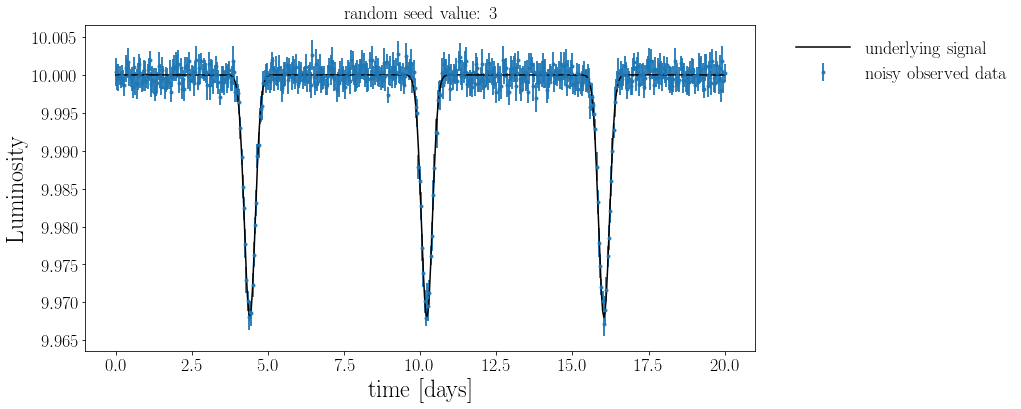

In [2]:
# First, let's generate some mock data, for which we know the true period.

noisy_data, clean_data, uncerts, timeax, true_periods = generate_fake_exoplanet_data(seed_val = 3,num_exoplanets=1)

In [3]:
# To fit this data, let us first write down a model for how we think the signal is created. 

#-------------------------------------------------------------------------------------------------
# This function creates an overall continuum luminosity with a periodic gaussian dip,
# that is designed to mimic a planet passing in front of a star. 

# The parameters of this model are:
#     timeax:     input array of times at which the model is computed. (in days)
#                 This should be the same array as the observation timeseries.
#     period:     The period (in days) of the transit
#     drop_fac:   The amount by which the luminosity drops when the planet transits.
#                 This is related to the size of the planet / radius of the orbit.
#     cont_lum:   The continuum luminosity of the star.
#     time_first: The time (in days) at which the first transit was observed

def generate_curve(timeax, period = 5, drop_fac = 0.01, cont_lum = 1.0, time_first = 1):
    
    time_loc = time_first
    curve = cont_lum - drop_fac*np.exp(-(timeax-time_loc)**2/(2*np.pi*10*(drop_fac**2)))
    while (time_loc < np.amax(timeax)):
        time_loc = time_loc + period
        curve = curve - drop_fac*np.exp(-(timeax-time_loc)**2/(2*np.pi*10*(drop_fac**2)))
    return curve

## Exercise 1.

Write a similar function for an alternate model with a rectangular dip (parametrized by some depth and width) every time an exoplanet passes in front of the star

In [ ]:
def generate_curve_box_model(timeax, period, depth, width, cont_lum, time_first):
    
    curve = np.zeros_like(timeax)
    
    #-------Fill in function here------------
    
    
    #----------------------------------------    
    
    return curve

-----------------------------------------------------------------------------------

## Now let's fit the data. 

Initially, we'll be using the `scipy.optimize.curve_fit` module. This is a reasonably simple set of functions that can be used for curve fitting. It estimates both the best-fit parameters, as well as the covariances.

The general usage is:

    curve_fit( function_to_optimize, x_axis_data, y_axis_data, parameter_bounds )

You can find the detailed api [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

Estimates for continuum: (9.978, 10.018)
True period: 5.8181 days.
Estimated period: 5.8187 days.
Estimated luminosity drop factor: 3.18e-02
Estimated continuum luminosity: 10.000
Estimated time of first transit: 4.396 days.


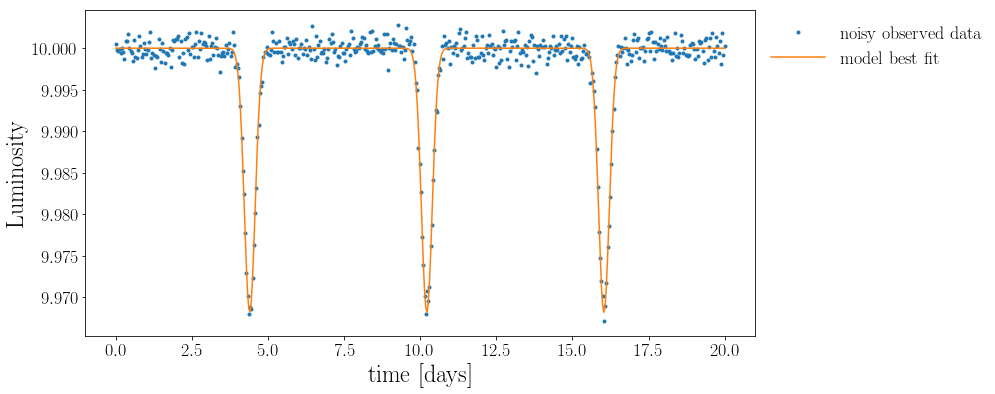

In [4]:
# the curve_fit algorithm searches through parameter space to find 
# the set of parameters that best describes the data. 

# for this to work optimally, it is generally good practice to 
# provide bounds for the parameter search.

# for the continuum luminosity of the star, we estimate the bounds 
# by considering the distribution of noisy data, assuming the excursions 
# due to transits don't make a significant overall difference to the continuum

continuum_lower_bound = np.nanmean(noisy_data) - 3*np.nanstd(noisy_data)
continuum_upper_bound = np.nanmean(noisy_data) + 3*np.nanstd(noisy_data)

print('Estimates for continuum: (%.3f, %.3f)' %(continuum_lower_bound, continuum_upper_bound))

# for the period, we require at least two transits for detection, so the period should lie
# between 0 and t_obs/2

# for the drop factor, we make an educated guess depending on the telecsope observing limits

# finally, for the time of first transit, we assume this happens within the first 10 days of observation

# This gives us: 

popt, pcov = curve_fit(generate_curve, timeax, 
                       noisy_data,bounds=([0,0,continuum_lower_bound,0.0],
                                          [np.amax(timeax)/2.0,0.1,continuum_upper_bound,10]))

# Running this function gives us 
# popt, the optimal parameters, and
# pcov, the parameter covariances.

# Let's see if the estimated period matches the true period of the planet in our data:

print('True period: %.4f' %true_periods,'days.')
print('Estimated period: %.4f' %popt[0],'days.')
print('Estimated luminosity drop factor: %.2e' %popt[1])
print('Estimated continuum luminosity: %.3f' %popt[2])
print('Estimated time of first transit: %.3f' %popt[3],'days.')

# Finally, let's visualize the model fit with optimal parameters.

plt.figure(figsize=(12,6))
plt.plot(timeax,noisy_data,'.',label = 'noisy observed data')
plt.plot(timeax,generate_curve(timeax,*popt),label = 'model best fit')
plt.xlabel('time [days]',fontsize=24)
plt.ylabel('Luminosity',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18,edgecolor='w',bbox_to_anchor=(1,1))
plt.show()

True period: 5.8181 days.
Estimated period: 2.6446 days.
Estimated luminosity drop factor: 7.74e-01
Estimated continuum luminosity: 13.105
Estimated time of first transit: -6.446 days.


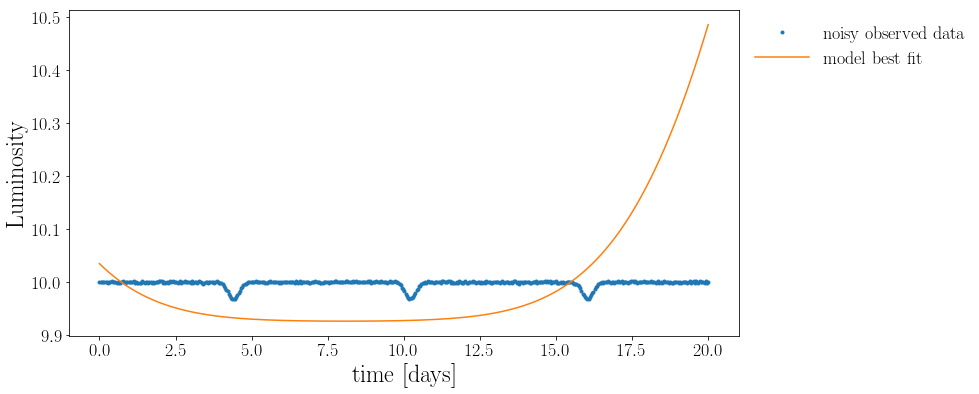

In [5]:
# Since the parameter space the module has to search over is extremely large, 
# not specifying the bounds can sometimes yield unphysical results, as seen below:

popt, pcov = curve_fit(generate_curve, timeax, noisy_data)

# Let's see if the estimated period matches the true period of the planet in our data:

print('True period: %.4f' %true_periods,'days.')
print('Estimated period: %.4f' %popt[0],'days.')
print('Estimated luminosity drop factor: %.2e' %popt[1])
print('Estimated continuum luminosity: %.3f' %popt[2])
print('Estimated time of first transit: %.3f' %popt[3],'days.')

# Finally, let's visualize the model fit with optimal parameters.

plt.figure(figsize=(12,6))
plt.plot(timeax,noisy_data,'.',label = 'noisy observed data')
plt.plot(timeax,generate_curve(timeax,*popt),label = 'model best fit')
plt.xlabel('time [days]',fontsize=24)
plt.ylabel('Luminosity',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18,edgecolor='w',bbox_to_anchor=(1,1))
plt.show()

## Exercise 2.

See what happens when you change the parameter bounds. Can you come up with better constraints using just the input data?

Consider bounds for each parameter: 
- period, 
- amplitude of dips, 
- continuum luminosity and 
- time of first transit

---------------------------------------------------------------------------------------

## Exercise 3. 

Using the box model that you developed in exercise 1, try to fit the following noisy data. What period do you find?

In [ ]:
noisy_data_ex2, clean_data_ex2, uncerts, timeax, true_periods = generate_fake_exoplanet_data(seed_val = 3,num_exoplanets=1,box=True)

# Case 2: Two exoplanets with strong signals.

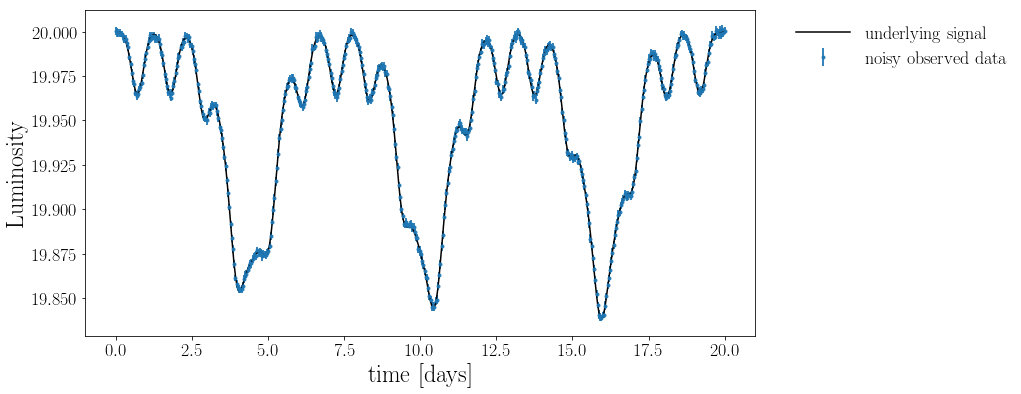

In [6]:
# As before, we first generate our mock data, we could set `num_exoplanets` = 2,
# but to be more illustrative, we can just make two separate curves and just add them

[noisy_data_p1, clean_data_p1, 
 uncerts_p1, timeax, true_periods_p1] = generate_fake_exoplanet_data(seed_val = 15,
                                                               num_exoplanets=1,
                                                               radii_ratios_scale=0.6,
                                                               SNR = 0.00001,verbose=False)

[noisy_data_p2, clean_data_p2, 
 uncerts_p2, timeax, true_periods_p2] = generate_fake_exoplanet_data(seed_val = 3,
                                                               num_exoplanets=1,
                                                               radii_ratios_scale=0.2,
                                                               SNR = 0.0001,verbose=False)

clean_data = clean_data_p1 + clean_data_p2
noisy_data = noisy_data_p1 + noisy_data_p2
uncerts = np.sqrt((uncerts_p1**2 + uncerts_p2**2))

plt.figure(figsize=(12,6))
plt.plot(timeax,clean_data,'k-',label='underlying signal')
plt.errorbar(timeax,noisy_data,yerr = uncerts,lw=0,elinewidth=2,
             marker='.',label='noisy observed data',alpha=0.9)
plt.legend(fontsize=18,bbox_to_anchor=(1.4,1),edgecolor='w')
plt.xlabel('time [days]',fontsize=24)
plt.ylabel('Luminosity',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


In [7]:
# To fit this data, let us modify our model to now include parameters for 2 planets..

#-------------------------------------------------------------------------------------------------
# This function creates an overall continuum luminosity with a periodic gaussian dip,
# that is designed to mimic a planet passing in front of a star. 

# The parameters of this model are:
#     timeax:     input array of times at which the model is computed. (in days)
#                 This should be the same array as the observation timeseries.
#     period:     The period (in days) of the transit
#     drop_fac:   The amount by which the luminosity drops when the planet transits.
#                 This is related to the size of the planet / radius of the orbit.
#     cont_lum:   The continuum luminosity of the star.
#     time_first: The time (in days) at which the first transit was observed

def generate_curve_2planets(timeax, 
                   period1 = 5, drop_fac1 = 0.01, cont_lum = 1.0, time_first1 = 1,
                   period2 = 3, drop_fac2 = 0.02, time_first2 = 2):
    
    time_loc = time_first1
    curve = cont_lum - drop_fac1*np.exp(-(timeax-time_loc)**2/(2*np.pi*10*(drop_fac1**2)))
    while (time_loc < np.amax(timeax)):
        time_loc = time_loc + period1
        curve = curve - drop_fac1*np.exp(-(timeax-time_loc)**2/(2*np.pi*10*(drop_fac1**2)))
        
    time_loc = time_first2
    curve = curve - drop_fac2*np.exp(-(timeax-time_loc)**2/(2*np.pi*10*(drop_fac2**2)))
    while (time_loc < np.amax(timeax)):
        time_loc = time_loc + period2
        curve = curve - drop_fac2*np.exp(-(timeax-time_loc)**2/(2*np.pi*10*(drop_fac2**2)))    
        
    return curve

#plt.plot(timeax,generate_curve_2planets(timeax))
#plt.show()

## Exercise 3

Write a function that can generate a curve for a general number of exoplanets, taking num_exoplanets as an input argument

--------------------------------------------------------------------------------------------

Estimates for continuum: (19.945, 20.087)
Estimated continuum luminosity [star]: 20.052
True periods: 1.0873 and 5.8181 days.
-------------------------------------------------------------------
Estimated period [planet 1]: 5.8205 days.
Estimated luminosity drop factor [planet 1]: 1.28e-01
Estimated time of first transit [planet 1]: 4.397 days.
-------------------------------------------------------------------
Estimated period [planet 2]: 1.0582 days.
Estimated luminosity drop factor [planet 2: 7.13e-02
Estimated time of first transit [planet 2: 0.000 days.
-------------------------------------------------------------------


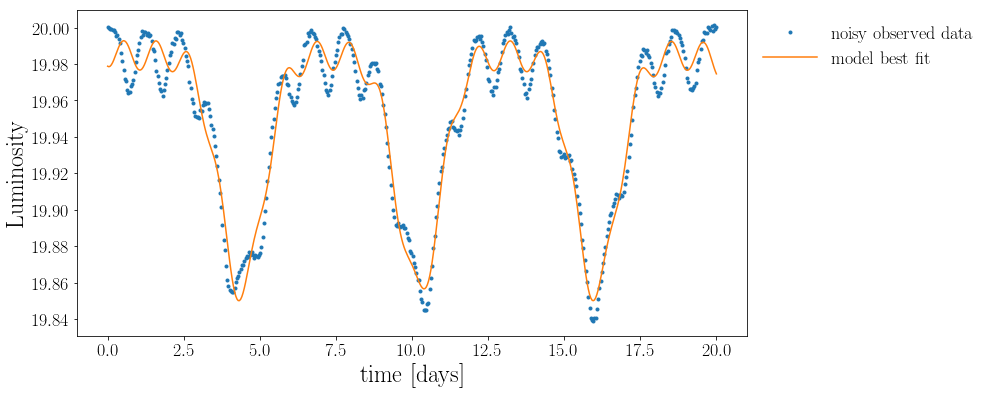

In [8]:
# the curve_fit algorithm searches through parameter space to find 
# the set of parameters that best describes the data. 

# for this to work optimally, it is generally good practice to 
# provide bounds for the parameter search.

# for the continuum luminosity of the star, we estimate the bounds 
# by considering the distribution of noisy data, assuming the excursions 
# due to transits don't make a significant overall difference to the continuum

continuum_lower_bound = np.nanmean(noisy_data) - 0.1*np.nanstd(noisy_data)
continuum_upper_bound = np.nanmean(noisy_data) + 3*np.nanstd(noisy_data)

print('Estimates for continuum: (%.3f, %.3f)' %(continuum_lower_bound, continuum_upper_bound))

# for the period, we require at least two transits for detection, so the period should lie
# between 0 and t_obs/2

per_bd = np.amax(timeax)/2

# for the drop factor, we make an educated guess depending on the telecsope observing limits

# finally, for the time of first transit, we assume this happens within the first 10 days of observation

# This gives us: 

popt, pcov = curve_fit(generate_curve_2planets, timeax, 
                       noisy_data,bounds=([0.0,1e-2,20,0.1,0.0,1e-2,0.0],
                                          [per_bd,0.2,continuum_upper_bound,10,per_bd/5,0.1,2]),
                      method = 'dogbox')

# Running this function gives us 
# popt, the optimal parameters, and
# pcov, the parameter covariances.

# Let's see if the estimated period matches the true period of the planet in our data:

print('Estimated continuum luminosity [star]: %.3f' %popt[2])
print('True periods: %.4f and %.4f' %(true_periods_p1, true_periods_p2),'days.')
print('-------------------------------------------------------------------')
print('Estimated period [planet 1]: %.4f' %popt[0],'days.')
print('Estimated luminosity drop factor [planet 1]: %.2e' %popt[1])
print('Estimated time of first transit [planet 1]: %.3f' %popt[3],'days.')
print('-------------------------------------------------------------------')
print('Estimated period [planet 2]: %.4f' %popt[4],'days.')
print('Estimated luminosity drop factor [planet 2: %.2e' %popt[5])
print('Estimated time of first transit [planet 2: %.3f' %popt[6],'days.')
print('-------------------------------------------------------------------')

# Finally, let's visualize the model fit with optimal parameters.

plt.figure(figsize=(12,6))
plt.plot(timeax,noisy_data,'.',label = 'noisy observed data')
plt.plot(timeax,generate_curve_2planets(timeax,*popt),label = 'model best fit')
plt.xlabel('time [days]',fontsize=24)
plt.ylabel('Luminosity',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18,edgecolor='w',bbox_to_anchor=(1,1))
plt.show()

# Case 3: A single exoplanet with signal drift.

In [ ]:
# Often, astronomical measurements may have little to large amounts of signal drift, 
# due to temperature effects on the instrument, or even unlikely cases like solar photons causing torque.

# Here we make a simple polynomial model to try to account for signal drift and try to recover our true parameters.

In [9]:
# First, let's generate some mock data, for which we know the true period.

noisy_data, clean_data, uncerts, timeax, true_periods = generate_fake_exoplanet_data(seed_val = 3,num_exoplanets=1,verbose=False)

# now let's add drift to it using out simple model:

noisy_data_with_drift, drift_params = add_drift(timeax,noisy_data)

### Let's try fitting this data as-is.

Estimates for continuum: (9.964, 10.018)
True period: 5.8181 days.
Estimated period: 4.8085 days.
Estimated luminosity drop factor: 1.47e-02
Estimated continuum luminosity: 9.992
Estimated time of first transit: 5.414 days.


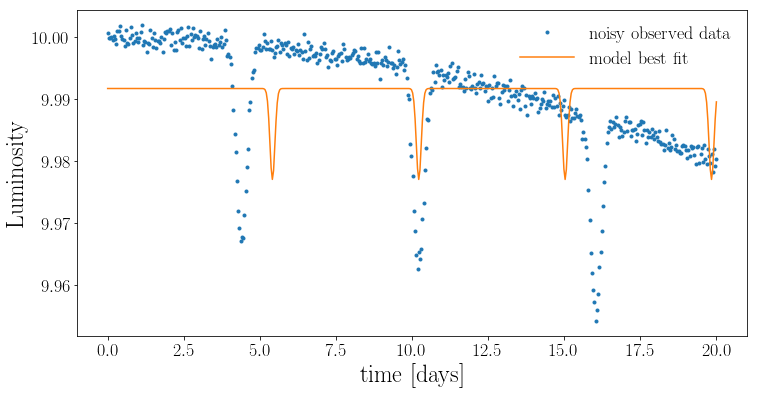

In [10]:
# the curve_fit algorithm searches through parameter space to find 
# the set of parameters that best describes the data. 

# for this to work optimally, it is generally good practice to 
# provide bounds for the parameter search.

# for the continuum luminosity of the star, we estimate the bounds 
# by considering the distribution of noisy data, assuming the excursions 
# due to transits don't make a significant overall difference to the continuum

continuum_lower_bound = np.nanmean(noisy_data_with_drift) - 3*np.nanstd(noisy_data_with_drift)
continuum_upper_bound = np.nanmean(noisy_data_with_drift) + 3*np.nanstd(noisy_data_with_drift)

print('Estimates for continuum: (%.3f, %.3f)' %(continuum_lower_bound, continuum_upper_bound))

# for the period, we require at least two transits for detection, so the period should lie
# between 0 and t_obs/2

# for the drop factor, we make an educated guess depending on the telecsope observing limits

# finally, for the time of first transit, we assume this happens within the first 10 days of observation

# This gives us: 

popt, pcov = curve_fit(generate_curve, timeax, 
                       noisy_data_with_drift,bounds=([0,0,continuum_lower_bound,0.0],
                                          [np.amax(timeax)/2.0,0.1,continuum_upper_bound,10]))

# Running this function gives us 
# popt, the optimal parameters, and
# pcov, the parameter covariances.

# Let's see if the estimated period matches the true period of the planet in our data:

print('True period: %.4f' %true_periods,'days.')
print('Estimated period: %.4f' %popt[0],'days.')
print('Estimated luminosity drop factor: %.2e' %popt[1])
print('Estimated continuum luminosity: %.3f' %popt[2])
print('Estimated time of first transit: %.3f' %popt[3],'days.')

# Finally, let's visualize the model fit with optimal parameters.

plt.figure(figsize=(12,6))
plt.plot(timeax,noisy_data_with_drift,'.',label = 'noisy observed data')
plt.plot(timeax,generate_curve(timeax,*popt),label = 'model best fit')
plt.xlabel('time [days]',fontsize=24)
plt.ylabel('Luminosity',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18,edgecolor='w',bbox_to_anchor=(1,1))
plt.show()

We find that the fit is completely thrown off due to the drift. 
To extract our parameters accuarately we thus need to correct for drift before fitting.

## Correcting for drift:

Let's model the data as 

$$ L_{combined} = L_{signal} + N(0,\sigma_i) + L_{drift} $$

where $L_{drift}$ is some function of time. From looking at the data, it appears that a polynomial would approximate the overall drift well.

Having decided that, we now need to find out what order of polynomial works best for our purposes. 

In [12]:
# To fit this data, let us first write down a model for how we think the signal is created. 
# Since the drift looks more complicated than a linear model, let's try a quadratic curve to approximate the drift.

#-------------------------------------------------------------------------------------------------
# This function creates an overall continuum luminosity with a periodic gaussian dip,
# that is designed to mimic a planet passing in front of a star. 

# The parameters of this model are:
#     timeax:      input array of times at which the model is computed. (in days)
#                  This should be the same array as the observation timeseries.
#     period:      The period (in days) of the transit
#     drop_fac:    The amount by which the luminosity drops when the planet transits.
#                  This is related to the size of the planet / radius of the orbit.
#     cont_lum:    The continuum luminosity of the star.
#     time_first:  The time (in days) at which the first transit was observed
#------------------------------------------------------------------------------------
#     drift_p0:    First parameter in a quadratic drift model
#     drift_p1:    Second parameter in a quadratic drift model
#     drift_p2:    Third parameter in a quadratic drift model
#     drift_scale: Overall scale of the drifting signal

def generate_curve_with_drift(timeax, period = 5, drop_fac = 0.01, cont_lum = 1.0, time_first = 1, 
                               drift_p0 = 1, drift_p1 = 1, drift_p2 = 1, drift_scale = 0):
    
    time_loc = time_first
    curve = cont_lum - drop_fac*np.exp(-(timeax-time_loc)**2/(2*np.pi*10*(drop_fac**2)))
    while (time_loc < np.amax(timeax)):
        time_loc = time_loc + period
        curve = curve - drop_fac*np.exp(-(timeax-time_loc)**2/(2*np.pi*10*(drop_fac**2)))
        
    drift_signal = drift_p0 + drift_p1**timeax + drift_p2*(timeax**2)
    scaled_drift_signal = (drift_signal / np.amax(np.abs(drift_signal))) * drift_scale
    
    curve_with_drift = curve + scaled_drift_signal
    
    return curve_with_drift

### Jointly fitting the continuum + drift:

Estimates for continuum: (9.964, 10.018)
True period: 5.8181 days.
Estimated period: 4.8201 days.
Estimated luminosity drop factor: 1.03e-02
Estimated continuum luminosity: 9.990
Estimated time of first transit: 5.408 days.


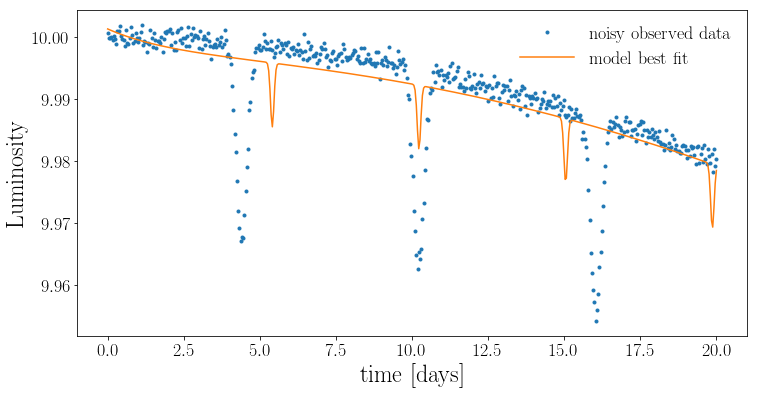

In [13]:


# the curve_fit algorithm searches through parameter space to find 
# the set of parameters that best describes the data. 

# for this to work optimally, it is generally good practice to 
# provide bounds for the parameter search.

# for the continuum luminosity of the star, we estimate the bounds 
# by considering the distribution of noisy data, assuming the excursions 
# due to transits don't make a significant overall difference to the continuum

continuum_lower_bound = np.nanmean(noisy_data_with_drift) - 3*np.nanstd(noisy_data_with_drift)
continuum_upper_bound = np.nanmean(noisy_data_with_drift) + 3*np.nanstd(noisy_data_with_drift)

print('Estimates for continuum: (%.3f, %.3f)' %(continuum_lower_bound, continuum_upper_bound))

# for the period, we require at least two transits for detection, so the period should lie
# between 0 and t_obs/2

# for the drop factor, we make an educated guess depending on the telecsope observing limits

# finally, for the time of first transit, we assume this happens within the first 10 days of observation

# This gives us: 

popt, pcov = curve_fit(generate_curve_with_drift, timeax, 
                       noisy_data_with_drift,bounds=([0,0,continuum_lower_bound,0.0, -2.0,-1.0,-0.1,0.0],
                                          [np.amax(timeax)/2.0,0.1,continuum_upper_bound,10, 2.0,1.0,1.0,0.2]))

# Running this function gives us 
# popt, the optimal parameters, and
# pcov, the parameter covariances.

# Let's see if the estimated period matches the true period of the planet in our data:

print('True period: %.4f' %true_periods,'days.')
print('Estimated period: %.4f' %popt[0],'days.')
print('Estimated luminosity drop factor: %.2e' %popt[1])
print('Estimated continuum luminosity: %.3f' %popt[2])
print('Estimated time of first transit: %.3f' %popt[3],'days.')

# Finally, let's visualize the model fit with optimal parameters.

plt.figure(figsize=(12,6))
plt.plot(timeax,noisy_data_with_drift,'.',label = 'noisy observed data')
plt.plot(timeax,generate_curve_with_drift(timeax,*popt),label = 'model best fit')
plt.xlabel('time [days]',fontsize=24)
plt.ylabel('Luminosity',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18,edgecolor='w',bbox_to_anchor=(1,1))
plt.show()


Now let's try improving our bounds using the data.

This can be posed as a different problem than what we're trying to solve earlier, 
And we'll come back to this when we talk about marginalizing over nuisance parameters.

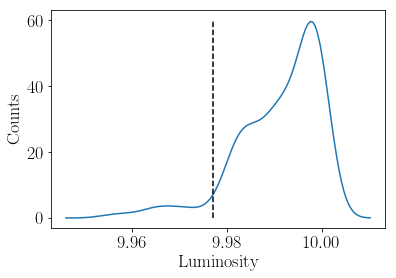

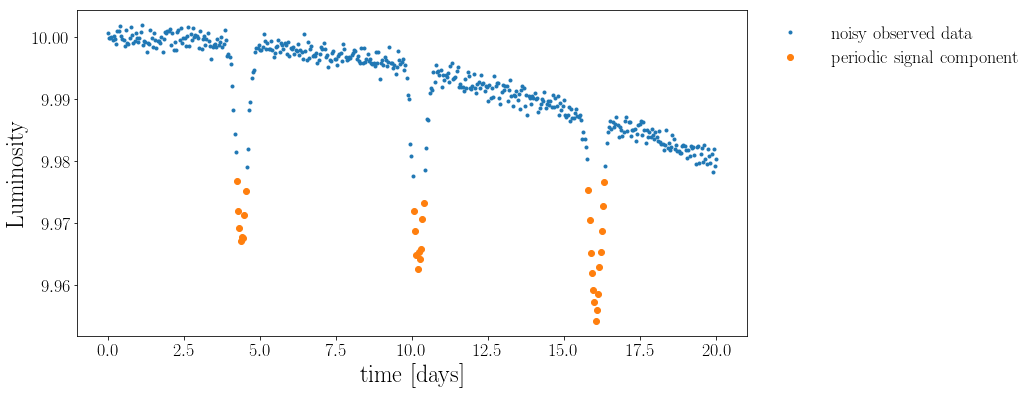

In [14]:
# Isolating the signal from the continuum

# First, we can plot a histogram of our luminosity observations

# Since the signal is a very small part of the overall data, we can
#     create a subset of our data by isolating the signal and fitting that
#     to guess the period, and then repeating our joint fitting procedure.

sns.kdeplot(noisy_data_with_drift)
plt.plot([9.977,9.977],[0,60],'k--')
plt.xlabel('Luminosity',fontsize=18)
plt.ylabel('Counts',fontsize=18)
plt.show()

mask1 = (noisy_data_with_drift < 9.99)
subsample1 = noisy_data_with_drift[mask1]

mask2 = (noisy_data_with_drift < 9.977)
subsample2 = noisy_data_with_drift[mask2]


plt.figure(figsize=(12,6))
plt.plot(timeax,noisy_data_with_drift,'.',label = 'noisy observed data')
plt.plot(timeax[mask2],noisy_data_with_drift[mask2],'o',label = 'periodic signal component')
plt.xlabel('time [days]',fontsize=24)
plt.ylabel('Luminosity',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18,edgecolor='w',bbox_to_anchor=(1,1))
plt.show()



Estimates for continuum: (9.982, 10.018)
True period: 5.8181 days.
Estimated period: 5.8187 days.
Estimated luminosity drop factor: 3.18e-02
Estimated continuum luminosity: 9.994
Estimated time of first transit: 4.397 days.


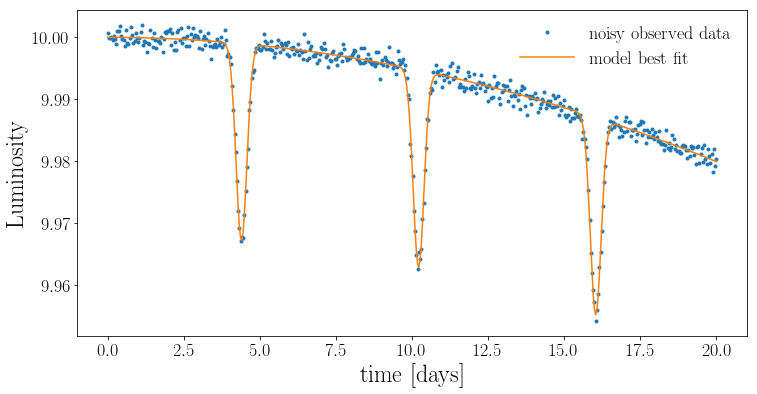

In [15]:
# Jointly fitting the continuum + drift:

# the curve_fit algorithm searches through parameter space to find 
# the set of parameters that best describes the data. 

# for this to work optimally, it is generally good practice to 
# provide bounds for the parameter search.

# for the continuum luminosity of the star, we estimate the bounds 
# by considering the distribution of noisy data, assuming the excursions 
# due to transits don't make a significant overall difference to the continuum

continuum_lower_bound = np.nanmean(noisy_data_with_drift) - 1*np.nanstd(noisy_data_with_drift)
continuum_upper_bound = np.nanmean(noisy_data_with_drift) + 3*np.nanstd(noisy_data_with_drift)

print('Estimates for continuum: (%.3f, %.3f)' %(continuum_lower_bound, continuum_upper_bound))

# First fit to masked data to better constrain bounds on period

popt, pcov = curve_fit(generate_curve_with_drift, timeax[mask2], noisy_data_with_drift[mask2],
                       bounds=([0,0,continuum_lower_bound,0.0, -2.0,-1.0,-0.1,0.0],
                               [np.amax(timeax)/2.0,0.1,continuum_upper_bound,10, 2.0,1.0,1.0,0.2]))

period_guess_lower = popt[0] - np.sqrt(pcov[0,0])
period_guess_upper = popt[0] + np.sqrt(pcov[0,0])

popt, pcov = curve_fit(generate_curve_with_drift, timeax, noisy_data_with_drift,
                       bounds=([period_guess_lower,0,continuum_lower_bound,0.0, -2.0,-1.0,-0.1,0.0],
                               [period_guess_upper,0.1,continuum_upper_bound,10, 2.0,1.0,1.0,0.2]))

# Running this function gives us 
# popt, the optimal parameters, and
# pcov, the parameter covariances.

# Let's see if the estimated period matches the true period of the planet in our data:

print('True period: %.4f' %true_periods,'days.')
print('Estimated period: %.4f' %popt[0],'days.')
print('Estimated luminosity drop factor: %.2e' %popt[1])
print('Estimated continuum luminosity: %.3f' %popt[2])
print('Estimated time of first transit: %.3f' %popt[3],'days.')

# Finally, let's visualize the model fit with optimal parameters.

plt.figure(figsize=(12,6))
plt.plot(timeax,noisy_data_with_drift,'.',label = 'noisy observed data')
plt.plot(timeax,generate_curve_with_drift(timeax,*popt),label = 'model best fit')
plt.xlabel('time [days]',fontsize=24)
plt.ylabel('Luminosity',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18,edgecolor='w',bbox_to_anchor=(1,1))
plt.show()


## Exercise 4.

Try fitting the continuum using a linear model, and see how it works.

As a stretch goal, try a whole range of polynomials, and use a model comparison method to determine the optimal number of parameters.

Try fitting the following curve as well, which has a more complicated drift:

In [ ]:
# First, let's generate some mock data, for which we know the true period.

noisy_data, clean_data, uncerts, timeax, true_periods = generate_fake_exoplanet_data(seed_val = 3,num_exoplanets=1,verbose=False)

# now let's add drift to it using out simple model:

noisy_data_with_drift, drift_params = add_drift(timeax,noisy_data, poly_order = 3)

## Exercise 5.

(after Session 2): Redo all the analysis we covered here incorporating the measurement uncertainties, report the goodness-of-fit and the parameter uncertainties for each case.

Can you use the `emcee` package to compute and visualize the full posteriors?

# An alternate method: Lomb-Scargle Periodograms:

For a more detailed explanation, try [Vanderplas (2017)](https://arxiv.org/pdf/1703.09824.pdf)

time taken to compute periodogram: 0.613


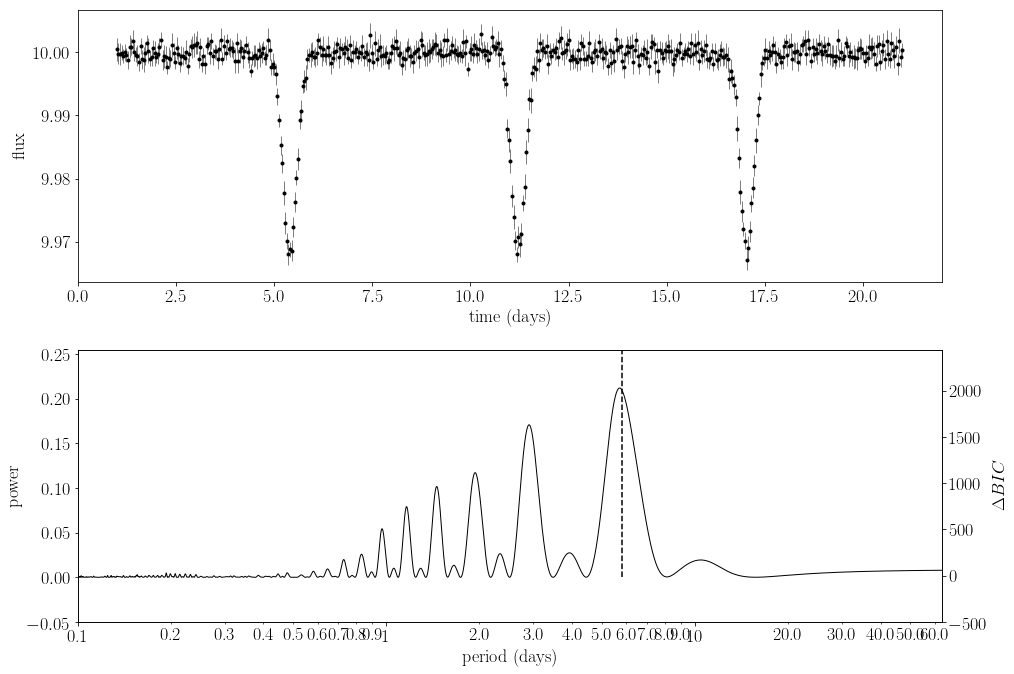

In [17]:
# Case 1 data:

noisy_data, clean_data, uncerts, timeax, true_periods = generate_fake_exoplanet_data(seed_val = 3,num_exoplanets=1,verbose=False)

lomb_scargle_analysis(timeax,noisy_data,uncerts,true_periods=true_periods)

time taken to compute periodogram: 0.601


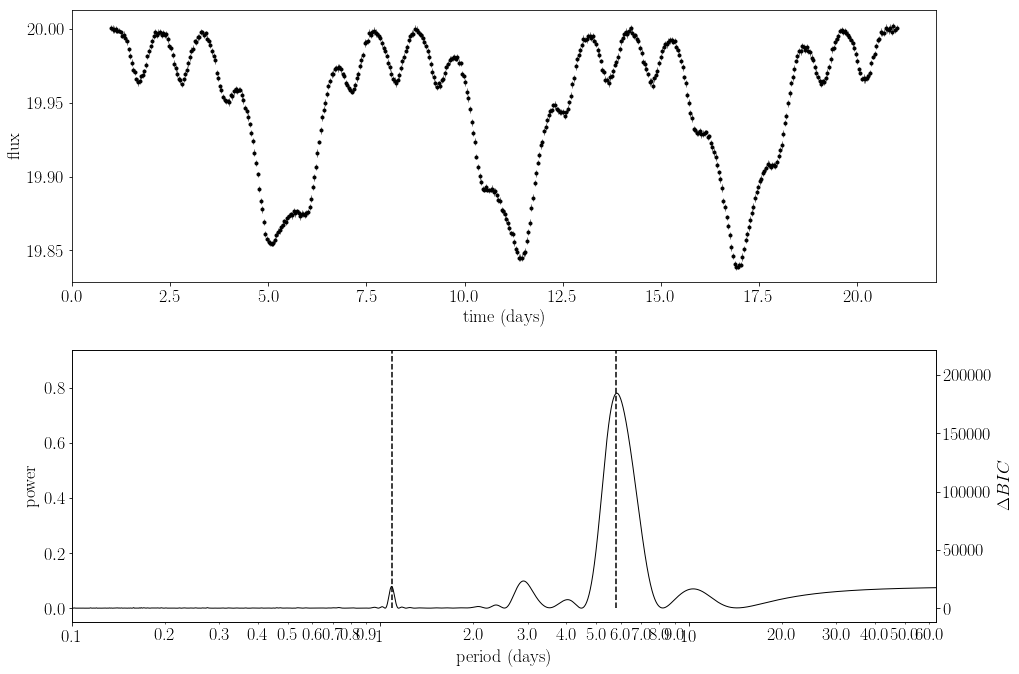

In [20]:
# Case 2: 2 planets

# As before, we first generate our mock data, we could set `num_exoplanets` = 2,
# but to be more illustrative, we can just make two separate curves and just add them

[noisy_data_p1, clean_data_p1, 
 uncerts_p1, timeax, true_periods_p1] = generate_fake_exoplanet_data(seed_val = 15,
                                                               num_exoplanets=1,
                                                               radii_ratios_scale=0.6,
                                                               SNR = 0.00001,verbose=False)

[noisy_data_p2, clean_data_p2, 
 uncerts_p2, timeax, true_periods_p2] = generate_fake_exoplanet_data(seed_val = 3,
                                                               num_exoplanets=1,
                                                               radii_ratios_scale=0.2,
                                                               SNR = 0.0001,verbose=False)

clean_data = clean_data_p1 + clean_data_p2
noisy_data = noisy_data_p1 + noisy_data_p2
uncerts = np.sqrt((uncerts_p1**2 + uncerts_p2**2))
true_periods_2p = np.array([true_periods_p1,true_periods_p2])

lomb_scargle_analysis(timeax,noisy_data,uncerts,true_periods=true_periods_2p)



time taken to compute periodogram: 0.597


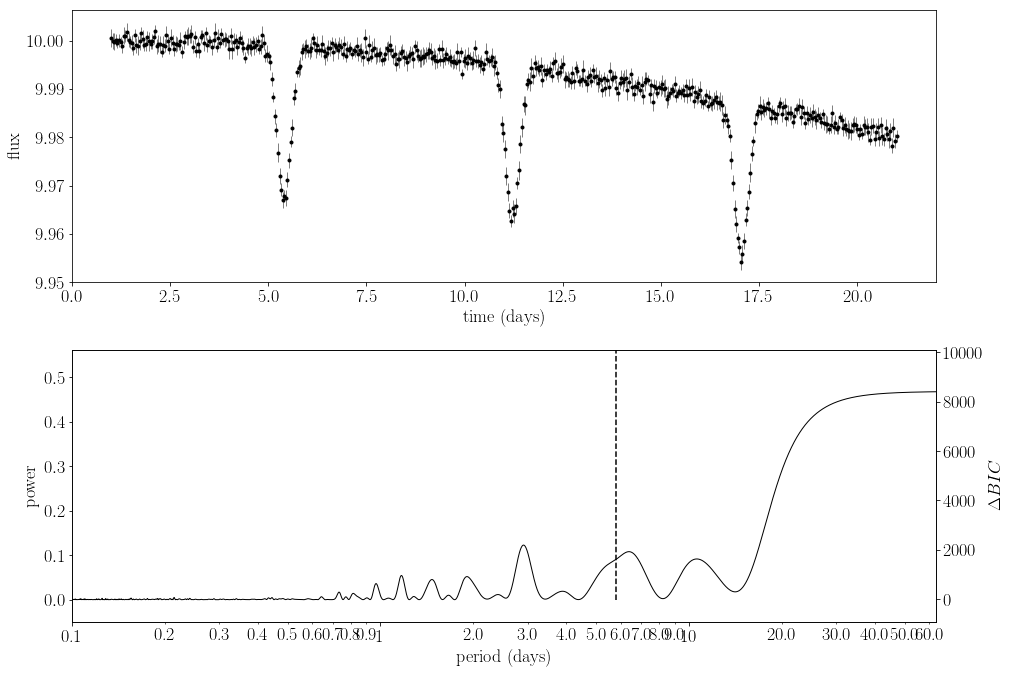

In [19]:
# Case 3: 1 planet + signal drift

# First, let's generate some mock data, for which we know the true period.

noisy_data, clean_data, uncerts, timeax, true_periods = generate_fake_exoplanet_data(seed_val = 3,num_exoplanets=1,verbose=False)

# now let's add drift to it using out simple model:

noisy_data_with_drift, drift_params = add_drift(timeax,noisy_data)

lomb_scargle_analysis(timeax,noisy_data_with_drift,uncerts,true_periods=true_periods)
